In [18]:
import pandas as pd
import seaborn as sns
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
gdp = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data Science/dataset/gdp-per-capita-worldbank.csv")
covid = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data Science/dataset/Worldwide Vaccine Data.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#We only want the 2017 GDP
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7109 entries, 0 to 7108
Data columns (total 4 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Entity                                               7109 non-null   object 
 1   Code                                                 5729 non-null   object 
 2   Year                                                 7109 non-null   int64  
 3   GDP per capita, PPP (constant 2017 international $)  7109 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 222.3+ KB


In [7]:
gdp.head()

,Entity,Code,Year,"GDP per capita, PPP (constant 2017 international $)"
0,Afghanistan,AFG,2002,1189.784668
1,Afghanistan,AFG,2003,1235.810063
2,Afghanistan,AFG,2004,1200.278013
3,Afghanistan,AFG,2005,1286.793659
4,Afghanistan,AFG,2006,1315.789117


In [19]:
#Keep only 2017 GDP
gdp = gdp[gdp.Year == 2017]

In [20]:
#Change column names
gdp = gdp.rename(columns={'Entity': 'Country','GDP per capita, PPP (constant 2017 international $)':'gdp_2017'})

In [21]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 15 to 7105
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Country   240 non-null    object 
 1   Code      195 non-null    object 
 2   Year      240 non-null    int64  
 3   gdp_2017  240 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 9.4+ KB


In [22]:
#Join the GDP of each country to the covid vaccine data
covid.head()

,Country,Doses administered per 100 people,Total doses administered,% of population vaccinated,% of population fully vaccinated
0,Afghanistan,14,5228706,12.0,9.4
1,Albania,80,2286235,40.0,36.0
2,Algeria,29,12545356,16.0,13.0
3,Angola,35,11164918,23.0,12.0
4,Argentina,168,75644660,85.0,72.0


In [29]:
#rename columns
covid = covid.rename(columns={'Doses administered per 100 people': 'doses/100','Total doses administered':'total_doses'
  ,'% of population vaccinated':'vax_per', '% of population fully vaccinated':'fully_vax_per'})

In [30]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Country        187 non-null    object 
 1   doses/100      187 non-null    int64  
 2   total_doses    187 non-null    int64  
 3   vax_per        187 non-null    float64
 4   fully_vax_per  187 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 7.4+ KB


In [31]:
#Check common Countries in both dataset
gdp['Country'].isin(covid['Country']).value_counts()

True     167
False     73
Name: Country, dtype: int64

In [33]:
#Join the two dataframes
full_data = pd.merge(covid,
                 gdp[['gdp_2017','Country']],
                 on='Country', 
                 how='inner')

In [34]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167 entries, 0 to 166
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Country        167 non-null    object 
 1   doses/100      167 non-null    int64  
 2   total_doses    167 non-null    int64  
 3   vax_per        167 non-null    float64
 4   fully_vax_per  167 non-null    float64
 5   gdp_2017       167 non-null    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 9.1+ KB


In [36]:
full_data.head()

,Country,doses/100,total_doses,vax_per,fully_vax_per,gdp_2017
0,Afghanistan,14,5228706,12.0,9.4,2058.400221
1,Albania,80,2286235,40.0,36.0,12770.975037
2,Algeria,29,12545356,16.0,13.0,11737.416159
3,Angola,35,11164918,23.0,12.0,7310.896589
4,Argentina,168,75644660,85.0,72.0,23597.117753


In [35]:
#Go through the full dataset
full_data.isnull().sum()

Country          0
doses/100        0
total_doses      0
vax_per          0
fully_vax_per    0
gdp_2017         0
dtype: int64

In [37]:
#Scale the numerical columns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = preprocessing.StandardScaler()
sig_num_col = ['doses/100', 'total_doses','vax_per', 'fully_vax_per', 'gdp_2017']
scaled_data = scaler.fit_transform(full_data[sig_num_col])

In [40]:
#Use PCA to reduce dimension of the data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_df = pca.fit_transform(scaled_data)

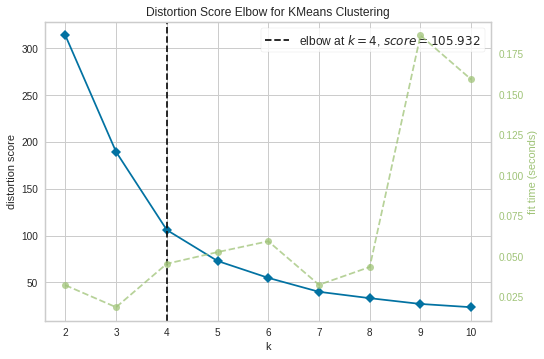

In [41]:
#Use elbow method to obtain optimal number of clusters for kmeans
#Same thing with pca
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KElbowVisualizer(KMeans(), k=10)
model.fit(pca_df)
model.show()

In [48]:
#Fit the model and compute the silhouette score
model = KMeans(n_clusters=4)
model.fit(pca_df)
from sklearn.metrics import silhouette_score
# silhouette score
print(silhouette_score(pca_df, model.labels_, metric='euclidean')) 

0.5152860112620353


In [49]:
#map the clusters back to the original dataset
pred = model.predict(pca_df)
clustered_data = pd.DataFrame(full_data)
clustered_data['cluster'] = pred
clustered_data.head()

,Country,doses/100,total_doses,vax_per,fully_vax_per,gdp_2017,cluster
0,Afghanistan,14,5228706,12.0,9.4,2058.400221,1
1,Albania,80,2286235,40.0,36.0,12770.975037,0
2,Algeria,29,12545356,16.0,13.0,11737.416159,1
3,Angola,35,11164918,23.0,12.0,7310.896589,1
4,Argentina,168,75644660,85.0,72.0,23597.117753,2


In [50]:
clustered_data['cluster'].value_counts()

2    58
1    54
0    54
3     1
Name: cluster, dtype: int64

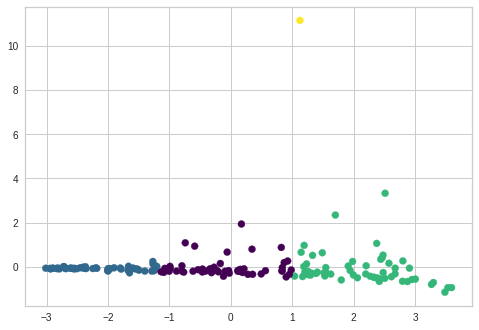

In [57]:
#Visualize the clusters
import matplotlib.pyplot as plt
plt.scatter(pca_df[:, 0], pca_df[:, 1], c=pred, cmap='viridis')

In [59]:
#The third cluster is an outlier, we can drop it
full_data = full_data[full_data.cluster != 3]

In [60]:
#Analyze the results
#group the information of each cluster by their averages
avg_df = full_data.groupby(['cluster'], as_index=False).mean()
avg_df.head()

,cluster,doses/100,total_doses,vax_per,fully_vax_per,gdp_2017
0,0,95.518519,2.619897e+07,50.722222,42.148148,14370.842001
1,1,24.277778,5.104330e+06,16.088889,10.592593,5232.754380
2,2,166.965517,4.935956e+07,77.000000,71.965517,39625.503357


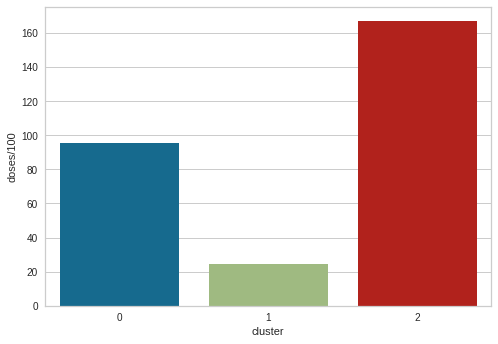

In [61]:
#Visualize the average dose per 100 people for each cluster
sns.barplot(x='cluster',y='doses/100',data=avg_df)

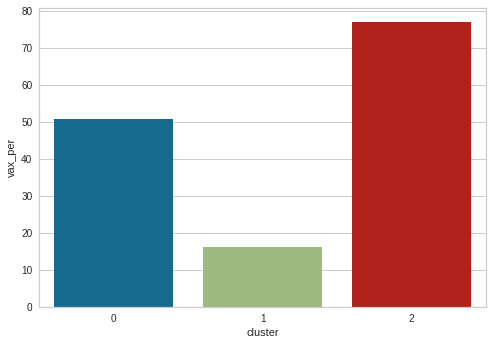

In [62]:
#Visualize the average percentage of popuplation who received at least 1 dose for each cluster
sns.barplot(x='cluster',y='vax_per',data=avg_df)

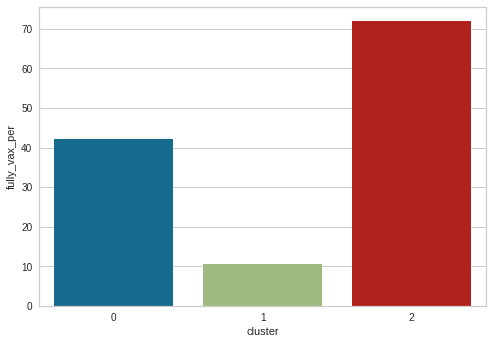

In [64]:
#Visualize the average percentage of popuplation who are fully vaccinated for each cluster
sns.barplot(x='cluster',y='fully_vax_per',data=avg_df)

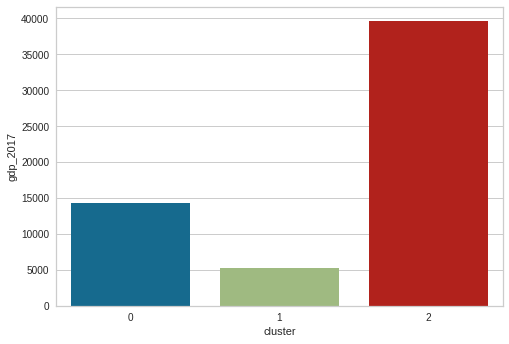

In [63]:
#Visualize the average GDP for each cluster
sns.barplot(x='cluster',y='gdp_2017',data=avg_df)

# Cluster 0
In this cluster of countries we notice that in average, 50% of the population has received at least one dose of the Covid-19 vaccine and 42% are fully vaccinated. We also notice that this cluster of countries has an average GDP of almost $15000.

# Cluster 1

In this cluster of countries we notice that in average, 16% of the population has received at least one dose of the Covid-19 vaccine and 10% are fully vaccinated. Those percentage are very low and make this countries more exposed to the Covid-19 outbreak. We also notice that this cluster of countries has an average GDP of almost $5300. This GDP is very low compared to the other clusters. This means that most countries in this cluster are poor countries. In conclusion, the reason behind this low vaccination rate is that most of these countries do not have the means to acquire the vaccine from the companies. 

# Cluster 2

In this cluster of countries we notice that in average, 77% of the population has received at least one dose of the Covid-19 vaccine and 71% are fully vaccinated. These vaccination rates are the highest among the clusters. We also notice that this cluster of countries has an average GDP of almost $40000. This is the highest GDP and it means these are first-world countries, especially western countries. Their high vaccination rate can be explained by the fact that these countries are wealthy enough to afford the vaccine doses.